<a href="https://colab.research.google.com/github/MDC55/Harvard-Forest-Classification/blob/main/HF_3m_hybridCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Library for common functions
# Kedar Patki
# %matplotlib qt
# TODO:
#https://www.spectralpython.net/class_func_ref.html
#https://stackoverflow.com/questions/59630622/how-to-enable-zoom-in-out-and-zoom-to-percentage-buttons-in-plots-pane-in-spyder
#-----------------------------------------------------------------------------------------
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 7.5 MB/s eta 0:00:00


In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

#from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral


In [ ]:
# Library for common functions
# Kedar Patki

# TODO:
#https://www.spectralpython.net/class_func_ref.html
#-----------------------------------------------------------------------------------------
from spectral import *
import numpy as np
import spectral.io.envi as envi
import matplotlib.pyplot as plt
# import pdb
#warnings.filterwarnings('ignore')



#-----------------------------------------------------------------------------------------
def open_envi_image( data_dir, basename ):
    hsi_hdr_file = data_dir + '/' + '{}.img.hdr'.format( basename )
    hsi_img_file = data_dir + '/' + '{}.img'.format( basename )
    img_envi = envi.open( hsi_hdr_file, hsi_img_file )
    img = img_envi.load()
    return img

def open_envi_gt_image( data_dir, basename ):
    hsi_hdr_file = data_dir + '/' + '{}.img.hdr'.format( basename )
    hsi_img_file = data_dir + '/' + '{}.img'.format( basename )
    img_envi = envi.open( hsi_hdr_file, hsi_img_file )
    img = img_envi.load()
    header_file = envi.read_envi_header(hsi_hdr_file)
    print(header_file)
    #print(header_file['bands'])
    return img,header_file



#img2=open_image(hsi_hdr_file).read_band(7)

def wavelength( data_dir, basename ):
    hsi_hdr_file = data_dir + '/' + '{}.img.hdr'.format( basename )
    hsi_img_file = data_dir + '/' + '{}.img'.format( basename )
    img_envi = envi.open( hsi_hdr_file, hsi_img_file )
    wavelength= img_envi.bands.centers
    bands=img_envi.bands
    return wavelength

def view_hsi_image_color(hsi_img):
    hsi_img_b=hsi_img[:,:,14]
    hsi_img_b_normalized=hsi_img_b/np.max(hsi_img_b)

    hsi_img_g=hsi_img[:,:,30]
    hsi_img_g_normalized=hsi_img_g/np.max(hsi_img_g)

    hsi_img_r=hsi_img[:,:,48]
    hsi_img_r_normalized=hsi_img_r/np.max(hsi_img_r)

    image=np.asarray(255*np.concatenate([hsi_img_b_normalized,
                                         hsi_img_g_normalized,
                                         hsi_img_r_normalized],axis=2),dtype=np.uint8)
    plt.imshow(image)
    plt.show()
    return image


def get_reflectance_image( input_radiance_img,img_with_cal_panel ):

    # Get ground-truth reflectance data
    # gt_reflectance_vec_calpanel_80 = 0.80 * np.ones( 224 )
    # gt_reflectance_vec_calpanel_20 = 0.20 * np.ones( 224 )


    # Interpolate and find ground-truth reflectance values at wavelengths of the hsi cube
    # hsi_wavelength_vec = np.array( input_radiance_img.bands.centers )

    # Manually selected cal panel pixels for 2 cal panels at 80% and 20%
    r1_calpanel_80, c1_calpanel_80 = 406, 595
    r2_calpanel_80, c2_calpanel_80 = 408, 590


    r1_calpanel_20, c1_calpanel_20 = 431, 105
    r2_calpanel_20, c2_calpanel_20 = 436, 107

    # Compute average of the pixels i.e. radiance vectors for each panel
    avg_calpanel_80_radiance_vec = ( img_with_cal_panel[r1_calpanel_80,c1_calpanel_80,:] +
                                    img_with_cal_panel[r2_calpanel_80,c2_calpanel_80,:] ) / 2

    avg_calpanel_20_radiance_vec = ( img_with_cal_panel[r1_calpanel_20,c1_calpanel_20,:] +
                                    img_with_cal_panel[r2_calpanel_20,c2_calpanel_20,:] ) / 2

    # Compute gain and offset ( a and b ) vectors
    # R=radiance, r=reflectance
    # using R = a*r + b per wavelength, and r = ( R - b ) / a
    # so, a = (R2-R1) / (r2-r1), b = (R1*r2 - R2*r1) / (r2-r1)
    a_vec = ( avg_calpanel_80_radiance_vec - avg_calpanel_20_radiance_vec ) / ( 0.8 - 0.2 )
    b_vec = ( avg_calpanel_20_radiance_vec * 0.8 - avg_calpanel_80_radiance_vec * 0.2 ) / ( 0.8 - 0.2 )

    # Create compensated hsi image i.e. reflectance image
    # reflectance_img_compensated = ( radiance_img - b_vec ) / a_vec
    reflectance_img = ( input_radiance_img - b_vec ) / a_vec

    # save image
    # envi.save_image( '../generated_images/{}_refl.img.hdr'.format( rootname ), reflectance_img )
    return reflectance_img



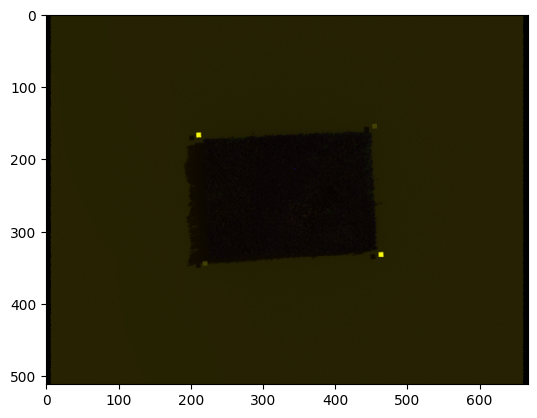

<ipython-input-4-4e528f3810dc>:98: RuntimeWarning: invalid value encountered in true_divide
  reflectance_img = ( input_radiance_img - b_vec ) / a_vec


{'description': "Truth data generated by DIRSIG 2023.14 (31bf3e6) 'BasicPlatform' plugin", 'samples': '667', 'lines': '512', 'bands': '9', 'header offset': '0', 'data type': '5', 'interleave': 'BIP', 'byte order': '0', 'band names': ['X Hit Coordinate [m]', 'Y Hit Coordinate [m]', 'Z Hit Coordinate [m]', 'Distance [m]', 'View Angle Cosine []', 'U Texture Coordinate []', 'V Texture Coordinate []', 'Dominant Material Index', 'Dominant Optical Property Index']}


/usr/local/lib/python3.10/dist-packages/spectral/io/spyfile.py:226: NaNValueWarning: Image data contains NaN values.
  warnings.warn('Image data contains NaN values.', NaNValueWarning)


Text(0.5, 1.0, 'Ground Truth')

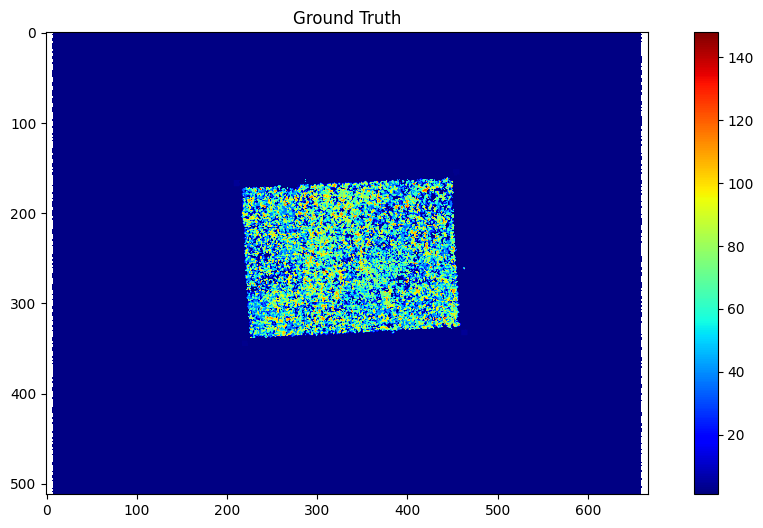

In [ ]:
#%%-------------------------------------------------------------------------------
#data_dir="F:/HarvardForestV3/1.5m_GSD"
data_dir='/content/drive/MyDrive/My Computer/Drive F/HarvardForestV3/1.5m_GSD'
basename='aviris'
img_with_cal_panel=open_envi_image(data_dir,basename)

data_dir='/content/drive/MyDrive/My Computer/Drive F/HarvardForestV3/3m_GSD'
#data_dir="F:/HarvardForestV3/3m_GSD"
basename='aviris'

img_rad=open_envi_image(data_dir,basename)

view_hsi_image_color(img_rad)

img_ref=get_reflectance_image(img_rad,img_with_cal_panel)
wl=wavelength(data_dir,basename)


#########################################################################
#%% Ground Truth Labelled Image
#data_dir="F:/HarvardForestV3/3m_GSD"
data_dir='/content/drive/MyDrive/My Computer/Drive F/HarvardForestV3/3m_GSD'
basename='aviris_truth'
#you can read the header into a Dictionary and then access the bands:
    #https://docs.python.org/3/tutorial/datastructures.html#dictionaries

truth_img,header_file=open_envi_gt_image(data_dir,basename)


from spectral import*
Labelled_data=truth_img.read_bands(7)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.axes_style('whitegrid')
fig = plt.figure(figsize=(12, 6))

#q = np.random.randint(data.shape[2])
q=7
plt.imshow(Labelled_data, cmap='jet')
plt.colorbar()
#plt.axis('off')
plt.title('Ground Truth')

Text(0.5, 1.0, 'band - 7')

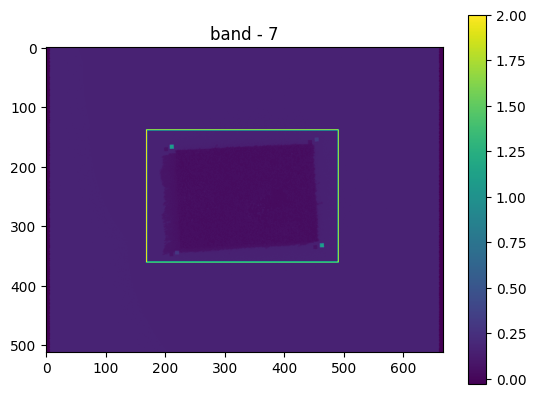

In [ ]:
#%%
def extract_rois(arr, x, y, w, h, intensity, line):
    roi = arr[y:y+h, x:x+w, :]

    bounding_box = arr
    bounding_box[y-line:y, x-line:x+w+line, :] = intensity # top line
    bounding_box[y:y+h, x-line:x, :] = intensity # left line
    bounding_box[y+h:y+h+line, x-line:x+w+line, :] = intensity # bottom line
    bounding_box[y:y+h, x+w:x+w+line, :] = intensity # right line

    return (roi, bounding_box)



coordinates = [
    (170, 140) #(x=horizontal,y=vertical)
]

rois = [] # returned ROIs
width = 320 # width and height
height = 220 # width and height
line = 2 # bounding box line width
intensity = 2 # bounding box line intensity
image_bboxed = None


#extract roi for test image
for coordinate in coordinates:
    (x, y) = coordinate
    (roi, image_bboxed) = extract_rois(
        img_ref, x, y, width, height, intensity, line)
    rois.append(roi)


# imshow(image_bboxed, (100, 100, 5))
# imshow(image_bboxed[:, :, 5])


sns.axes_style('whitegrid')
#fig = plt.figure(figsize=(12, 6))

#q = np.random.randint(data.shape[2])
q=7
plt.imshow(image_bboxed[:, :, q])
plt.colorbar()
#plt.axis('off')
plt.title(f'band - {q}')


Text(0.5, 1.0, 'band - 7')

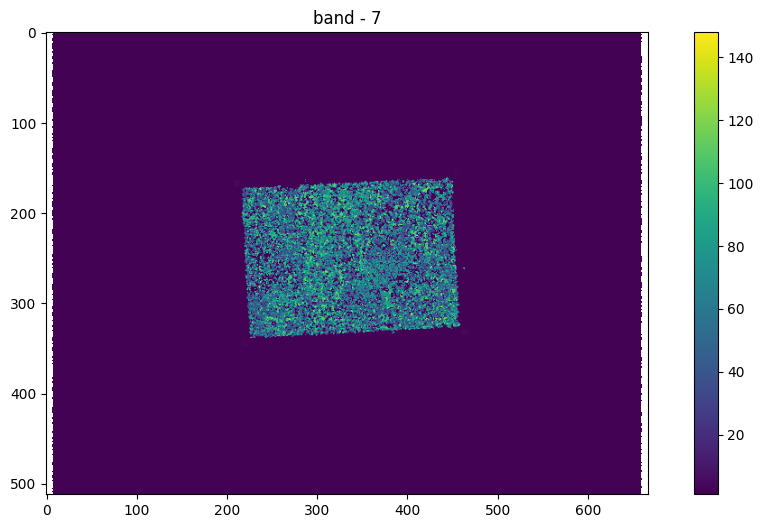

In [ ]:
#%%
#extract same roi for ground truth image
rois_gt = [] # returned ROIs
width = 320 # width and height
height = 220 # width and height
line = 2 # bounding box line width
intensity = 2 # bounding box line intensity
image_bboxed = None


for coordinate in coordinates:
    (x, y) = coordinate
    (roi_gt, image_bboxed) = extract_rois(
        truth_img, x, y, width, height, intensity, line)
    rois_gt.append(roi_gt)

from spectral import*
Labelled_data_roi=roi_gt.read_bands(7)

# imshow(image_bboxed, (100, 100, 5))
# imshow(image_bboxed[:, :, 5])

sns.axes_style('whitegrid')
fig = plt.figure(figsize=(12, 6))

#q = np.random.randint(data.shape[2])
q=7
plt.imshow(image_bboxed[:, :, q])
plt.colorbar()
#plt.axis('off')
plt.title(f'band - {q}')


In [ ]:
#%% combining 'acerpe':[82,9,81,63,53],'acerru':[34,40,71,45,39,70] into acer
#    'betual':[133,77,64,88,22],'betule':[113,93,68,27,42],'betupa':[89],'betupo':[47,121,119,78] into betu
#    'pinure':[37,104,110,15],'pinust':[131,102,28,76,46,33], into pinu
#    'queral':[69,36,120,16,49,25],'querru':[67,112,92,61,5,83,26,80,66,8,79,7], into quer

speciesToID = {
    'acer':[82,9,81,63,53,34,40,71,45,39,70],
    'aronme':[54,98,132,108],
    'bark':[65,62,117,135],
    'betu':[133,77,64,88,22,113,93,68,27,42,89,47,121,119,78],
    'castde':[116,14,115,51,50],
    'dead':[17,59,38,60,35,130],
    'fagugr':[123,72,57,96,18],
    'fraxni':[122],
    'hamavi':[74,12,85,55,75],
    'ilexve':[32,73,95,107,56],
    'kalmla':[20],
    'larila':[84],
    'lyonli':[127,124,105,129,126],
    'nemomu':[21,13,86,29,118],
    'nysssy':[6],
    'ostrvi':[94],
    'piceab':[114],
    'pinu':[37,104,110,15,131,102,28,76,46,33],
    'quer':[69,36,120,16,49,25,67,112,92,61,5,83,26,80,66,8,79,7],
    'rhodpr':[11,99,109],
    'soil':[19,128,23,31],
    'tsugca':[52,43,30,103,97,100],
    'ulmuam':[134],
    'vaccco':[44,91,125,48,90,10,41,111],
    'vibual':[58,106,101,24,87]
}

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
{1: ['acer'], 2: ['aronme'], 3: ['bark'], 4: ['betu'], 5: ['castde'], 6: ['fagugr'], 7: ['fraxni'], 8: ['hamavi'], 9: ['kalmla'], 10: ['larila'], 11: ['nemomu'], 12: ['nysssy'], 13: ['ostrvi'], 14: ['pinu'], 15: ['quer'], 16: ['rhodpr'], 17: ['ulmuam'], 18: ['vibual']}


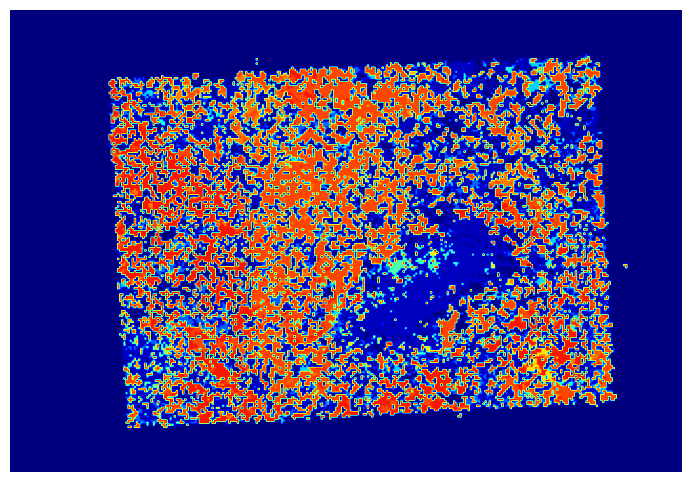

In [ ]:
#%%https://stackoverflow.com/questions/67761919/how-to-apply-a-lookup-to-a-label-image-with-more-than-256-labels
#https://realpython.com/iterate-through-dictionary-python/
# Create empty label array
labelArray = np.zeros_like(Labelled_data_roi)
labelsToSpecies = {}
# Create labels
# label = 1
# for species in speciesToID:
#     for value in speciesToID[species]:
#         indices = np.where(Labelled_data_roi == value)
#         labelArray[indices] = label
#         if label not in labelsToSpecies:
#             labelsToSpecies[label] = [species]
#     label += 1

label = 1
for species in speciesToID:
    for value in speciesToID[species]:
        # Find all locations where the value exists in the imgArray
        indices = np.where(Labelled_data_roi == value)
        labelArray[indices] = label
        if label not in labelsToSpecies:
            labelsToSpecies[label] = [species]
    label += 1  if len(indices[0]) > 0 and all(Labelled_data_roi[indices] == value) else 0

print(labelArray)

sns.axes_style('whitegrid')
fig = plt.figure(figsize=(12, 6))

#q = np.random.randint(data.shape[2])
q=7
plt.imshow(labelArray, cmap='jet')
#plt.colorbar()
plt.axis('off')
#plt.title('Ground Truth')

#print(labelsToSpecies)
labelsToSpecies_original=labelsToSpecies

# Convert labelArray elements to integers
labelArray = labelArray.astype(int)

# Count the number of samples for each class
class_counts = np.bincount(labelArray.flatten())

# Find the classes with less than two samples
classes_to_replace = np.where(class_counts < 2)[0]

# Replace the class labels with zero
for cls in classes_to_replace:
    labelArray[labelArray == cls] = 0

for key in classes_to_replace:
    labelsToSpecies.pop(key, None)

print(labelsToSpecies)

In [ ]:

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test



from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    newX = StandardScaler().fit_transform(newX)
    pca = PCA(n_components=numComponents)

    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca



def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX




def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
#         patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
test_ratio = 0.3
windowSize = 25

In [ ]:
X=roi
newX = np.reshape(X, (-1, X.shape[2]))
newX = np.nan_to_num(newX)
#newX=np.where(np.isnan(newX), 0, newX)
X = np.reshape(newX, (X.shape[0],X.shape[1], X.shape[2]))

# Handle missing or invalid values (e.g., NaN, infinity)
# = np.nan_to_num(X)

#y=Labelled_data_roi #ROI of the ground truth image
y=labelArray #modified labelled ground truth data


#X, y = loadData()

X.shape, y.shape


((220, 320, 224), (220, 320))

In [ ]:
K = 20
X,pca = applyPCA(X,numComponents=K)

X.shape


(220, 320, 20)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)


X.shape, y.shape


((32198, 25, 25, 20), (32198,))

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Convert ground truth labels to one-hot encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse=False)
y_ = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:

Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y_, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape


((22538, 25, 25, 20), (9660, 25, 25, 20), (22538, 18), (9660, 18))

In [ ]:

Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape


(22538, 25, 25, 20, 1)

In [ ]:
S = windowSize
L = K
output_units =  ytrain.shape[1]
#num_classes = len(np.unique(ytrain))
output_units

18

In [ ]:


## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 19, 19, 8, 32)


In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 20, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 14, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 10, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 8, 32)     13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 256)       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        147520    
                                                                 
 flatten (Flatten)           (None, 18496)             0     

In [ ]:

adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:


# checkpoint
filepath = "/content/drive/My Drive/Colab Notebooks/best-model.hdf5"
#filepath="F:/3D CNN/Notebooks/best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=50,validation_data=(Xtest, ytest), callbacks=callbacks_list)


Epoch 1/50
89/89 [==============================] - ETA: 0s - loss: 1.5759 - accuracy: 0.4724

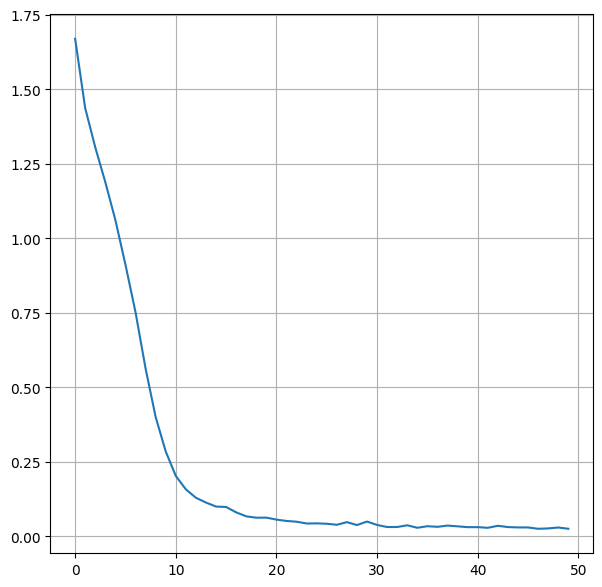

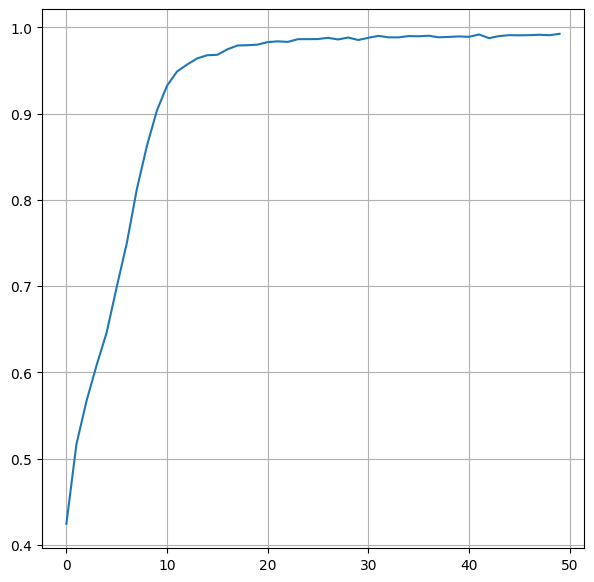

In [ ]:

plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])


plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['accuracy'])

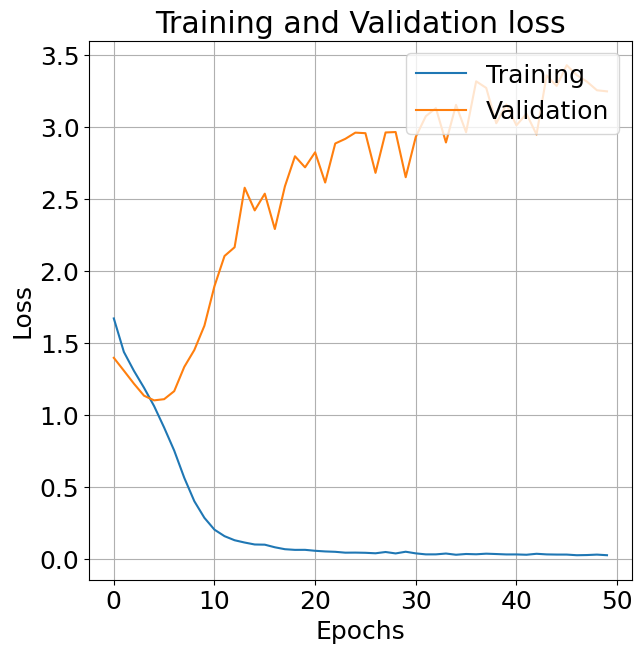

In [ ]:
## Plot Training and Validation loss and Accuracy
plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 18})
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation loss')
plt.legend(['Training','Validation'], loc='upper right')
#plt.savefig("IP_loss.eps")
plt.show()

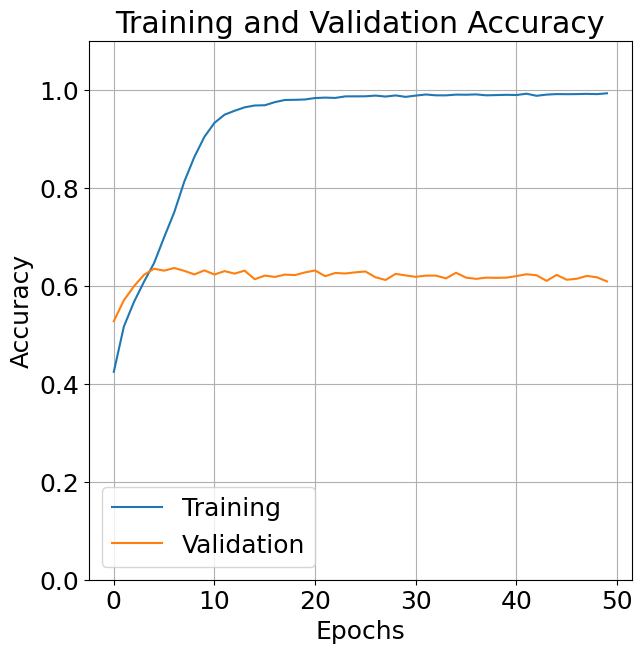

In [ ]:
## Plot Training and Validation Accuracy
plt.figure(figsize=(7,7))
plt.ylim(0,1.1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.legend(['Training','Validation'])
plt.grid()
#plt.savefig("IP_Accuracy.eps")
plt.show()

In [ ]:
loss, acc = model.evaluate(Xtest, ytest)
print(f"Accuracy: {acc*100}\nLoss: {loss}")

167/167 [==============================] - 2s 8ms/step - loss: 3.2455 - accuracy: 0.6088
Accuracy: 60.87854504585266
Loss: 3.245549201965332


In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)


167/167 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.62      0.67      0.65      1732
           1       0.00      0.00      0.00         2
           2       0.17      0.02      0.03        56
           3       0.25      0.19      0.22       356
           4       0.36      0.20      0.25       107
           5       1.00      0.05      0.10        19
           6       0.60      0.17      0.27        35
           7       0.29      0.10      0.14        21
           8       0.00      0.00      0.00         1
           9       0.60      0.12      0.21        24
          10       0.00      0.00      0.00         1
          11       0.22      0.05      0.09        37
          12       0.43      0.34      0.38       201
          13       0.66      0.71      0.69      1589
          14       0.64      0.68      0.66      1128
          15       0.50      0.11      0.18         9
          16       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(labelsToSpecies)

{1: ['acer'], 2: ['aronme'], 3: ['bark'], 4: ['betu'], 5: ['castde'], 6: ['fraxni'], 7: ['hamavi'], 8: ['kalmla'], 10: ['nemomu'], 11: ['nysssy'], 12: ['ostrvi'], 13: ['piceab'], 14: ['pinu'], 15: ['quer'], 16: ['rhodpr'], 17: ['ulmuam'], 18: ['vibual']}


In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)
classes =  ['1: acer', '2: aronme', '3: bark', '4: betu', '5: castde',
            '6: fagugr', '7: fraxni','8: hamavi', '9: kalmla', '10: larila',
            '11: nemomu','12: nysssy', '13: ostrvi', '14: pinu',
            '15: quer', '16: rhodpr',  '17: ulmuam', '18: vibual'
            ]
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test,target_names=classes)
print(classification)

167/167 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

     1: acer       0.62      0.67      0.65      1732
   2: aronme       0.00      0.00      0.00         2
     3: bark       0.17      0.02      0.03        56
     4: betu       0.25      0.19      0.22       356
   5: castde       0.36      0.20      0.25       107
   6: fraxni       1.00      0.05      0.10        19
   7: hamavi       0.60      0.17      0.27        35
   8: kalmla       0.29      0.10      0.14        21
  10: nemomu       0.00      0.00      0.00         1
  11: nysssy       0.60      0.12      0.21        24
  12: ostrvi       0.00      0.00      0.00         1
  13: piceab       0.22      0.05      0.09        37
    14: pinu       0.43      0.34      0.38       201
    15: quer       0.66      0.71      0.69      1589
  16: rhodpr       0.64      0.68      0.66      1128
  17: ulmuam       0.50      0.11      0.18         9
  18: vibual       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import  f1_score
#print("f1_score:",(f1_score(y_test, y_pred, average='micro')))

# f1_score(y_test, pred, average='micro')

from sklearn.metrics import cohen_kappa_score

print("Cohen Kappa Score :",cohen_kappa_score(y_pred_test, np.argmax(ytest, 1))*100)

Cohen Kappa Score : 46.90304410032601


<ipython-input-36-334b80d7f468>:13: RuntimeWarning: invalid value encountered in true_divide
  cmn = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]


{'aronme', 'vibual', 'ostrvi', 'nemomu'}


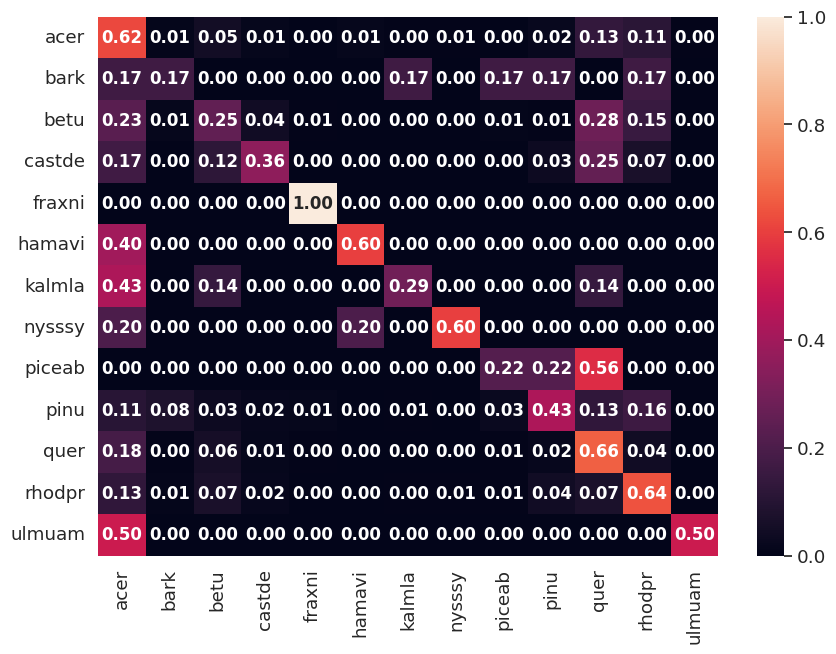

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10,7))
classes =   ['acer', 'aronme', 'bark', 'betu', 'castde',
            'fagugr', 'fraxni','hamavi', 'kalmla', 'larila',
            'nemomu','nysssy', 'ostrvi', 'pinu',
            'quer', 'rhodpr',  'ulmuam', 'vibual'
            ]

mat = confusion_matrix(np.add(y_pred_test, 1), np.add(np.argmax(ytest, 1), 1))
# Normalise
cmn = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(cmn, index = classes, columns = classes)

# # Default drop rows that contains nan values
df2=df_cm.dropna()
#print(df2)

#print(df2.columns.tolist())
# Get the list of index names
index_names = df2.index.tolist()
# Get the list of column names
column_names = df2.columns.tolist()
# Find the set intersection of the two lists
# unique_names = set(index_names).intersection(column_names)
# # Print the unique names
# print(unique_names)
# find the set difference between the two lists
names_diff = set(column_names)-set(index_names)

# print the result
print(names_diff)
df2=df2.drop(columns=names_diff)

sns.set(font_scale=1.2)
#sns.heatmap(df2, annot=True, fmt='.2f')
sns.heatmap(df2, annot=True, annot_kws={"size":12, "weight": "bold"},fmt='.2f')

plt.show()

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)

    target_names =['1: acer', '2: aronme', '3: betu' ,'5: hamavi',
                   '6: larlia', '7: ostrvi', '8: pinu','9: quer', '10: ulmuam'
                  ]

    classification = classification_report(np.argmax(y_test, axis=1), y_pred)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    print(f'Accuracy: {Test_accuracy}')
    #return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100
    return  oa*100,  aa*100, kappa*100


In [ ]:
reports(Xtest,ytest)